# 0.0 Imports

In [16]:
import warnings
import pandas as pd
import sweetviz as sv
import seaborn as sns

from tabulate import tabulate
from matplotlib import pyplot as plt
from pycorrcat import pycorrcat

## 0.1 Load data

In [17]:
feature_engineering = catalog.load("feature_engineering")

[09/21/23 20:57:12] INFO     Loading data from 'feature_engineering' (CSVDataSet)...            ]8;id=834844;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=912248;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [18]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    sns.set()
    warnings.filterwarnings('ignore')
    return None


notebook_settings()

# 4.0 Exploratory Data Analysis

In [19]:
exploratory_data_analysis = feature_engineering.copy()

exploratory_data_analysis.head()

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.490,29.020,3.770,8.460,82.740
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.080,3.580,6.810,0.770,40.240
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.850,12.880,3.790,3.310,35.820
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.750,11.010,3.280,2.960,33.000
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.270,8.890,10.220,1.000,31.370


## 4.1 Univariate Analysis

It is not necessary to execute the code, you can check the result in `/docs/SWEETVIZ_REPORT.html`.

In [20]:
# we will use sweetviz for uni- and bivariate automated analysis
my_report = sv.analyze(exploratory_data_analysis)
my_report.show_html(filepath='../docs/SWEETVIZ_REPORT.html', layout='widescreen')

                                             |          | [  0%]   00:00 -> (? left)

Report ../docs/SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### 4.1.1 Sweetviz's main analyses

Sweetviz generates several analytics and it is important to extract important content.

### 4.1.2 Response Variable

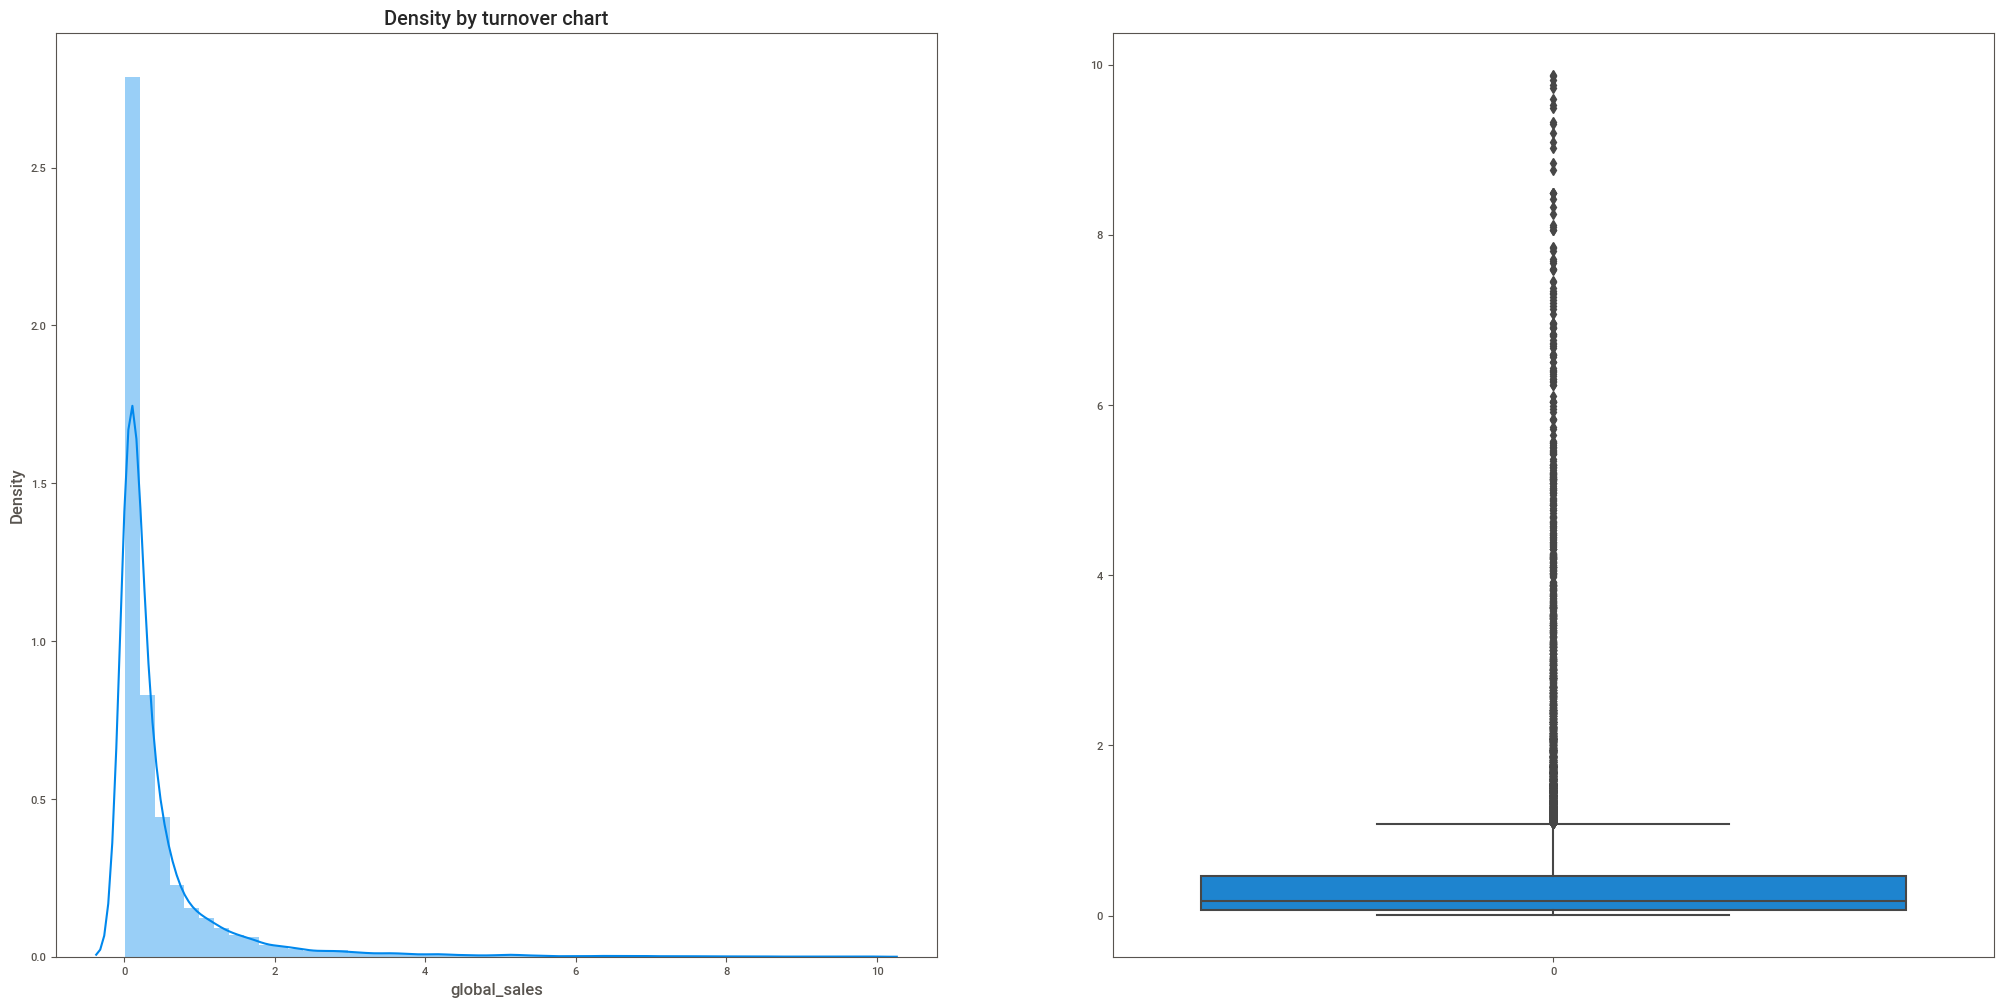

In [41]:
df_aux = exploratory_data_analysis[exploratory_data_analysis['global_sales'] < 10].reset_index(drop=True)

plt.subplot(1, 2, 1)
plt.title('Density by turnover chart')
sns.distplot(df_aux['global_sales'], kde=True)

plt.subplot(1, 2, 2)
sns.boxplot(df_aux['global_sales']);

### 4.1.3 Analysis of Video Games Sales Trends

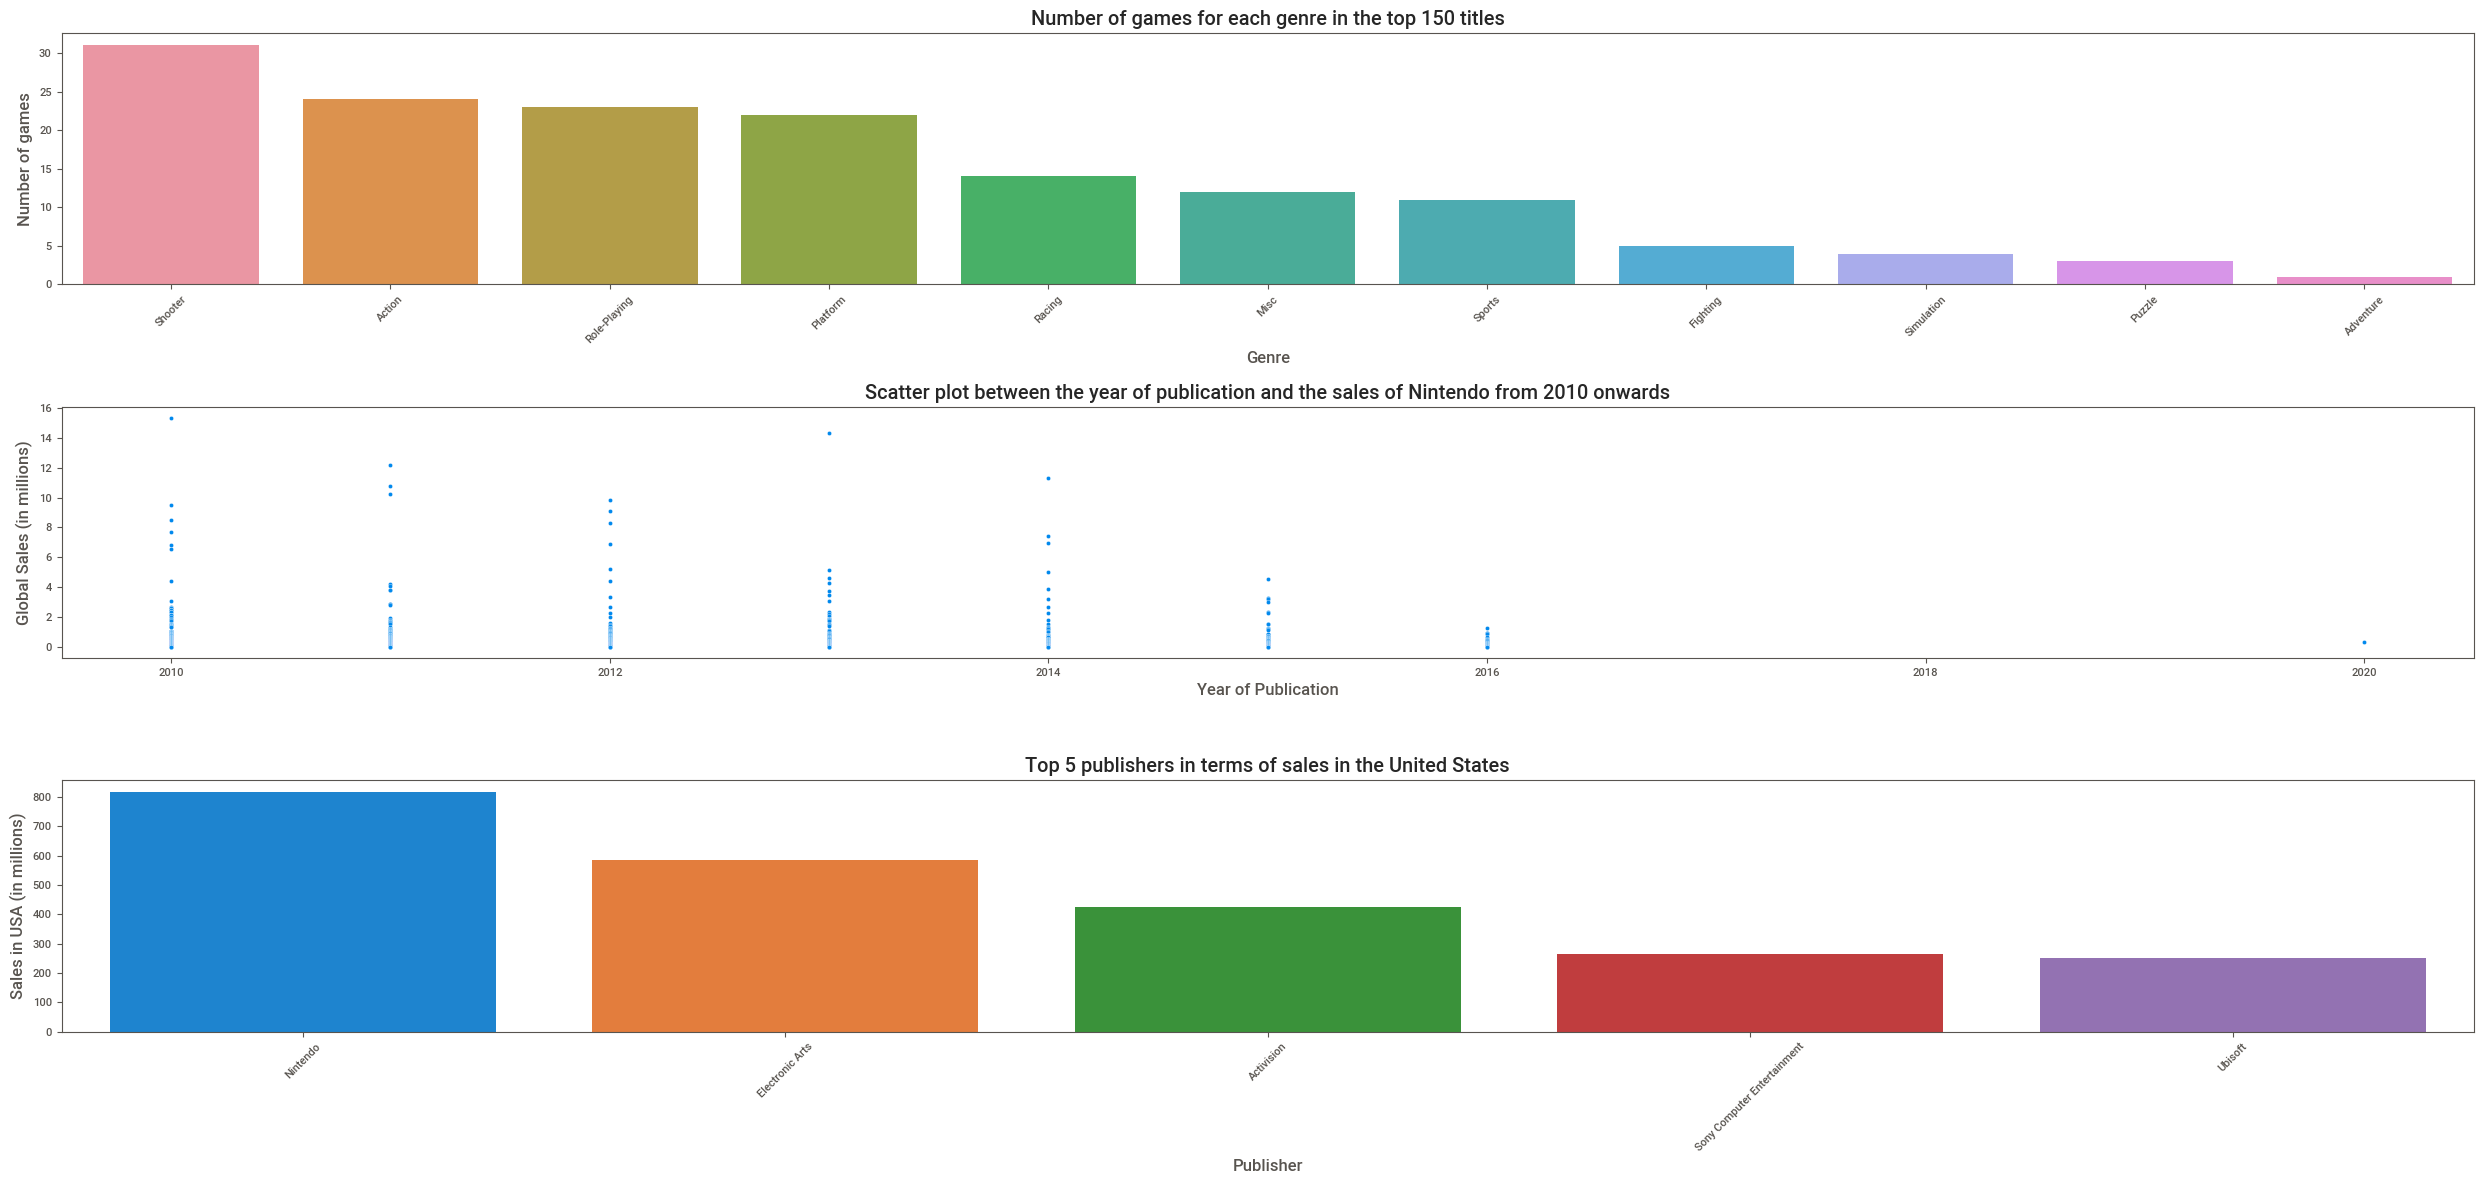

In [32]:
# Set up the figure and axes for subplots
fig, ax = plt.subplots(3, 1)

# 1. Histogram of how many games each genre has in the top 150 titles of the rank
top_150 = exploratory_data_analysis.head(150)
sns.countplot(data=top_150, x='genre', order=top_150['genre'].value_counts().index, ax=ax[0])
ax[0].set_title("Number of games for each genre in the top 150 titles")
ax[0].set_ylabel("Number of games")
ax[0].set_xlabel("Genre")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

# 2. Scatter plot between the year of publication and the sales of Nintendo from 2010 onwards

# Identify Nintendo platforms from our dataset (like Wii, WiiU, DS, 3DS)
nintendo_platforms = ['Wii', 'WiiU', 'DS', '3DS']

nintendo_sales = exploratory_data_analysis[(exploratory_data_analysis['platform'].isin(nintendo_platforms)) & (exploratory_data_analysis['year'] >= 2010)]
sns.scatterplot(data=nintendo_sales, x='year', y='global_sales', ax=ax[1])
ax[1].set_title("Scatter plot between the year of publication and the sales of Nintendo from 2010 onwards")
ax[1].set_ylabel("Global Sales (in millions)")
ax[1].set_xlabel("Year of Publication")

# 3. The top 5 publishers in terms of sales in the United States
top_publishers = exploratory_data_analysis.groupby('publisher')['na_sales'].sum().nlargest(5)
sns.barplot(x=top_publishers.index, y=top_publishers.values, ax=ax[2])
ax[2].set_title("Top 5 publishers in terms of sales in the United States")
ax[2].set_ylabel("Sales in USA (in millions)")
ax[2].set_xlabel("Publisher")
for tick in ax[2].get_xticklabels():
    tick.set_rotation(45)

plt.tight_layout()
plt.show();

## 4.2 Bivariate Analysis

### 1. Hypothesis: Action games have a sales median that's 10% higher than RPG games in the European market.

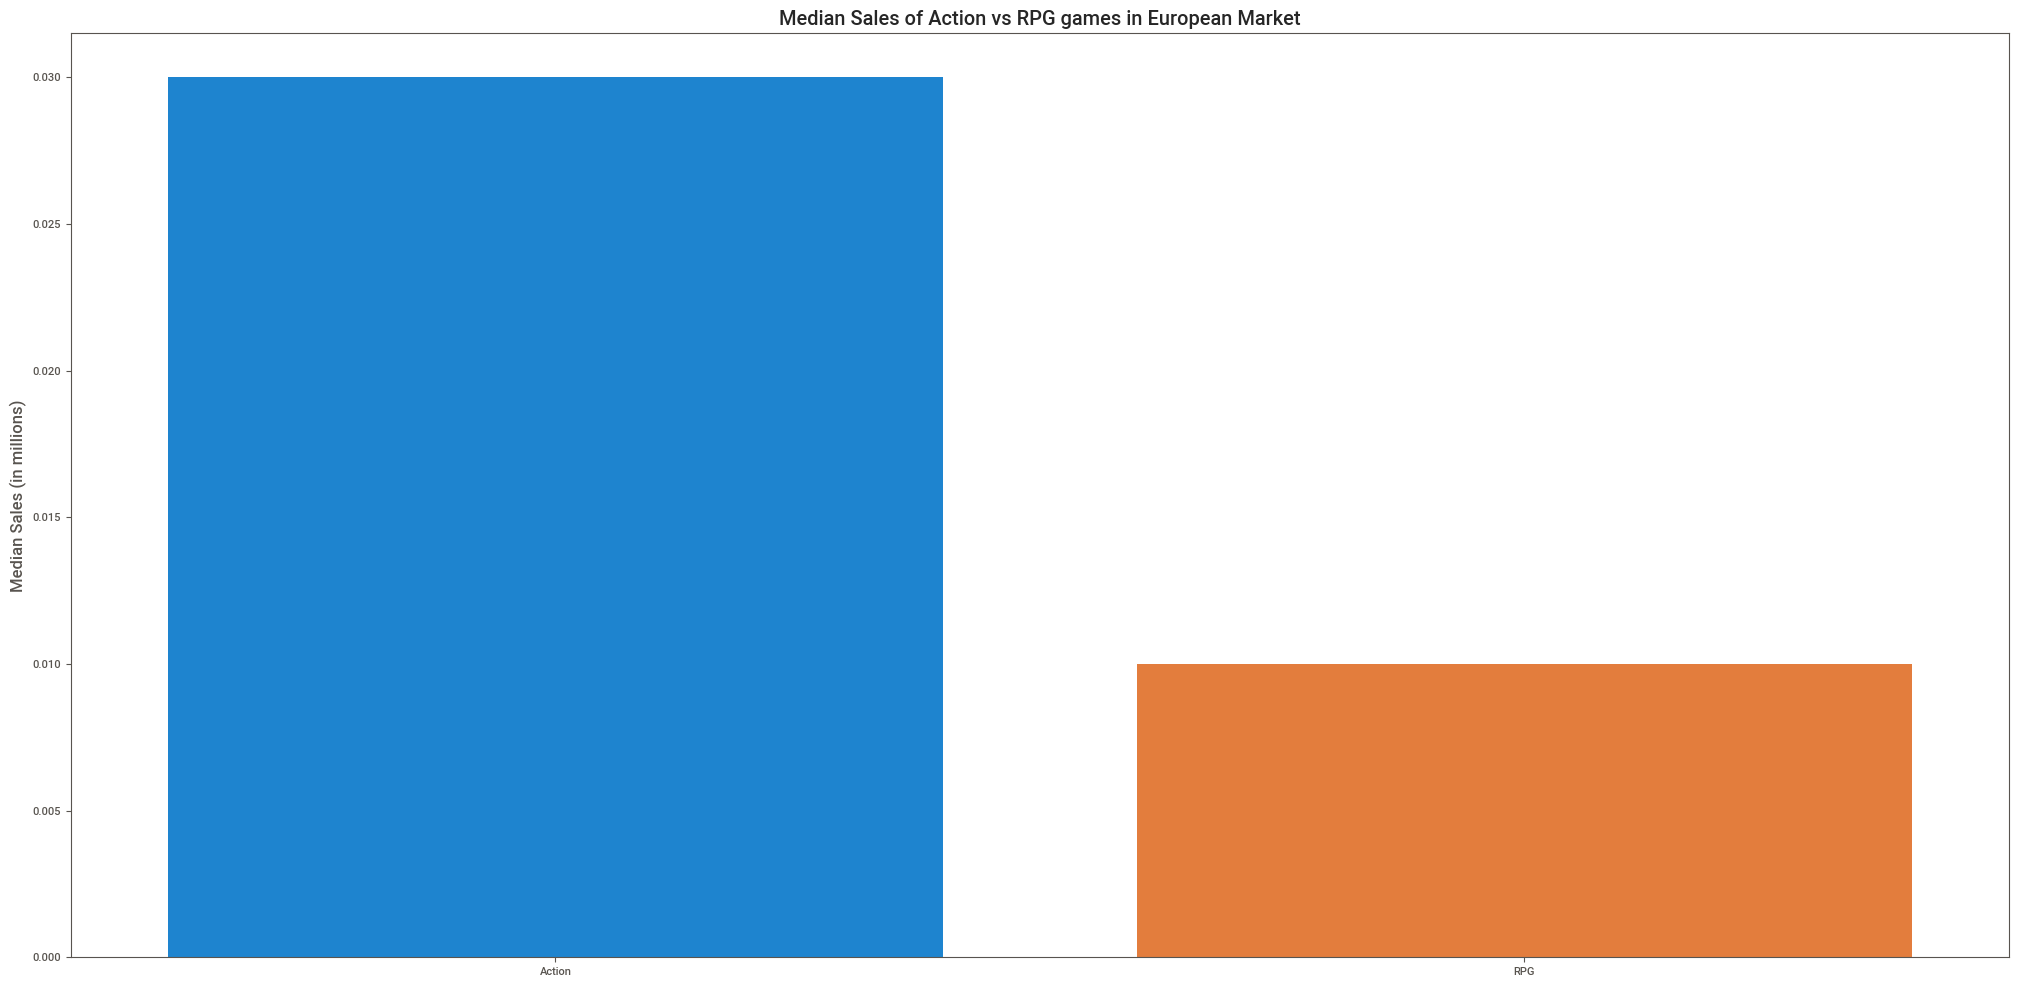

In [21]:
# Filter the data for Action and RPG games
action_games = exploratory_data_analysis[exploratory_data_analysis['genre'] == 'Action']
rpg_games = exploratory_data_analysis[exploratory_data_analysis['genre'] == 'Role-Playing']

# Calculate the median sales for both genres in the European market
medians = {
    'Action': action_games['eu_sales'].median(),
    'RPG': rpg_games['eu_sales'].median()
}

# Plot the medians
sns.barplot(x=list(medians.keys()), y=list(medians.values()))
plt.ylabel('Median Sales (in millions)')
plt.title('Median Sales of Action vs RPG games in European Market')
plt.show();

### 2. Hypothesis: Strategy games have 15% higher sales on PC platforms compared to sony platforms in the North American market.

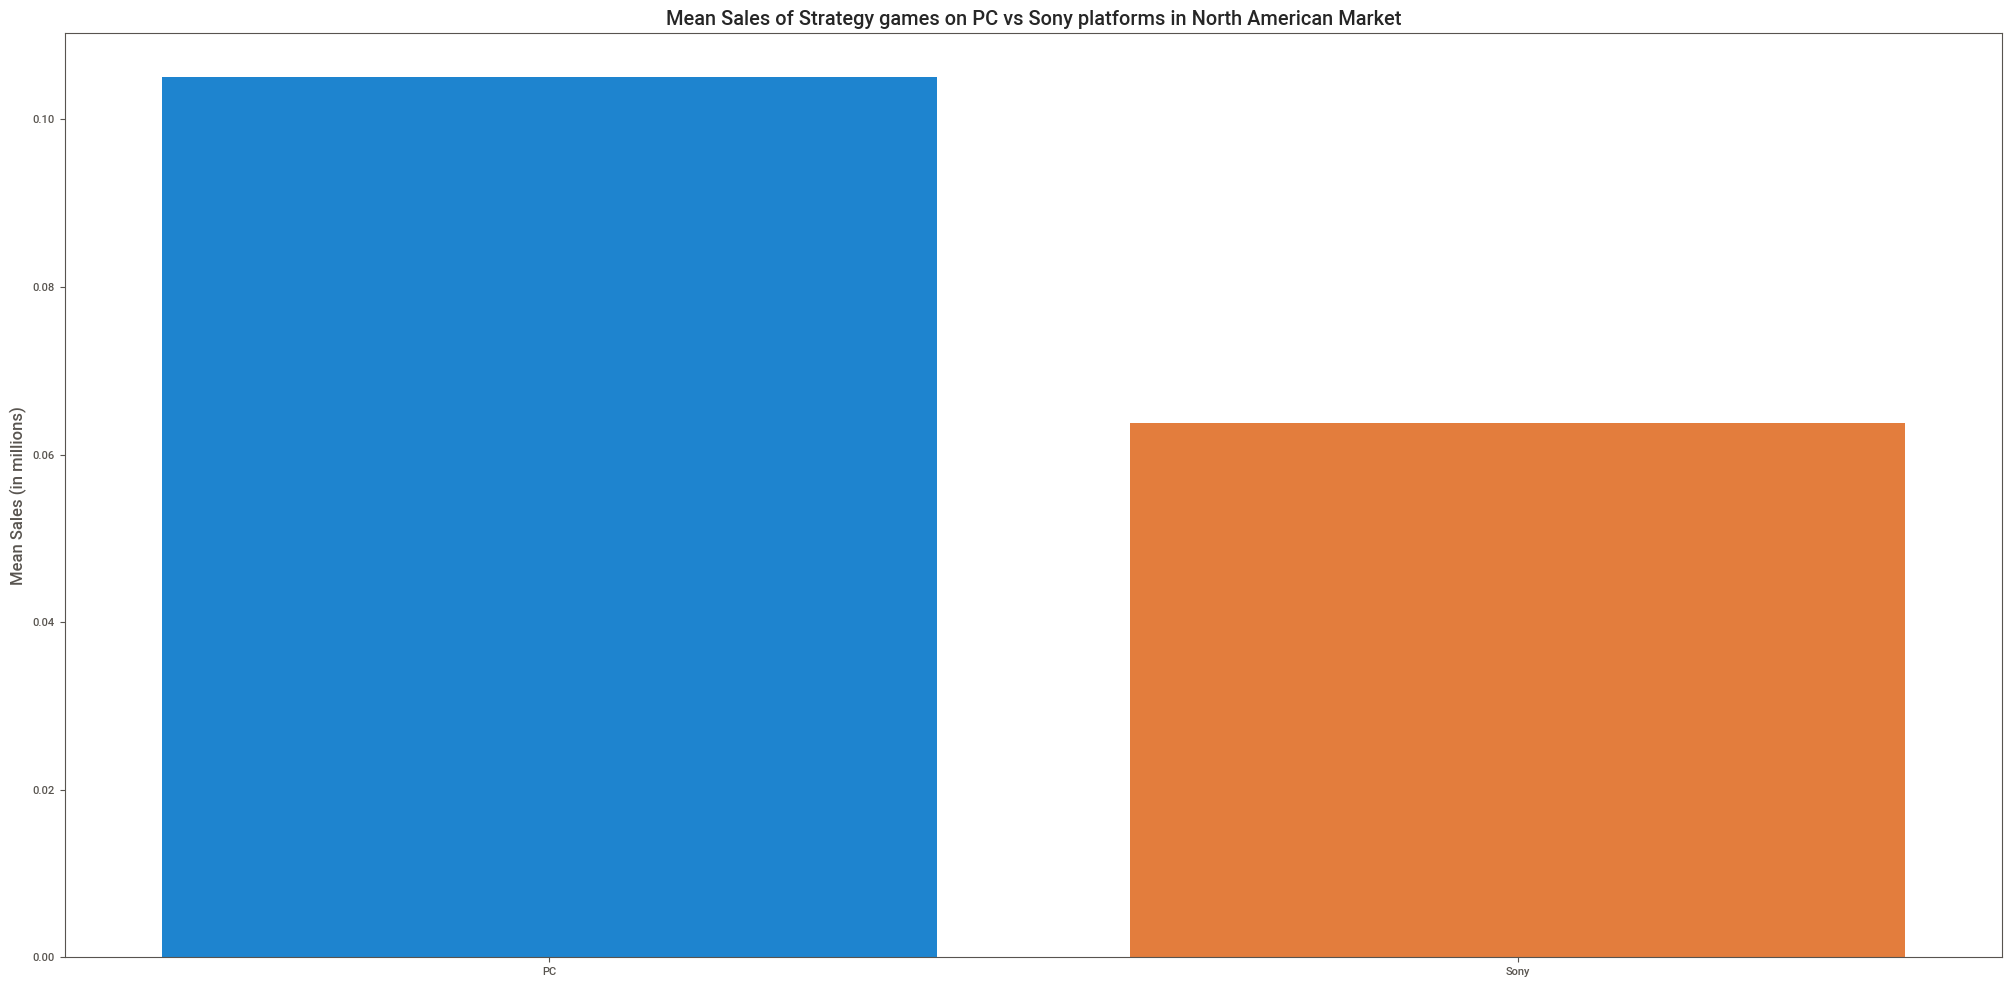

In [22]:
# Filter the data for Strategy games
strategy_games = exploratory_data_analysis[exploratory_data_analysis['genre'] == 'Strategy']

# Identify Sony platforms from our dataset (like PS2, PS3, PS4, etc.)
sony_platforms = [platform for platform in strategy_games['platform'].unique() if 'PS' in platform]

# Calculate the mean sales for Strategy games on PC and Sony platforms in the North American market
means = {
    'PC': strategy_games[strategy_games['platform'] == 'PC']['na_sales'].mean(),
    'Sony': strategy_games[strategy_games['platform'].isin(sony_platforms)]['na_sales'].mean()
}

# Plot the means
sns.barplot(x=list(means.keys()), y=list(means.values()))
plt.ylabel('Mean Sales (in millions)')
plt.title('Mean Sales of Strategy games on PC vs Sony platforms in North American Market')
plt.show();

### 3. Hypothesis: Adventure games released on microsoft and sony consoles see a 10% increase in overall sales in the European market compared to those released on PC.

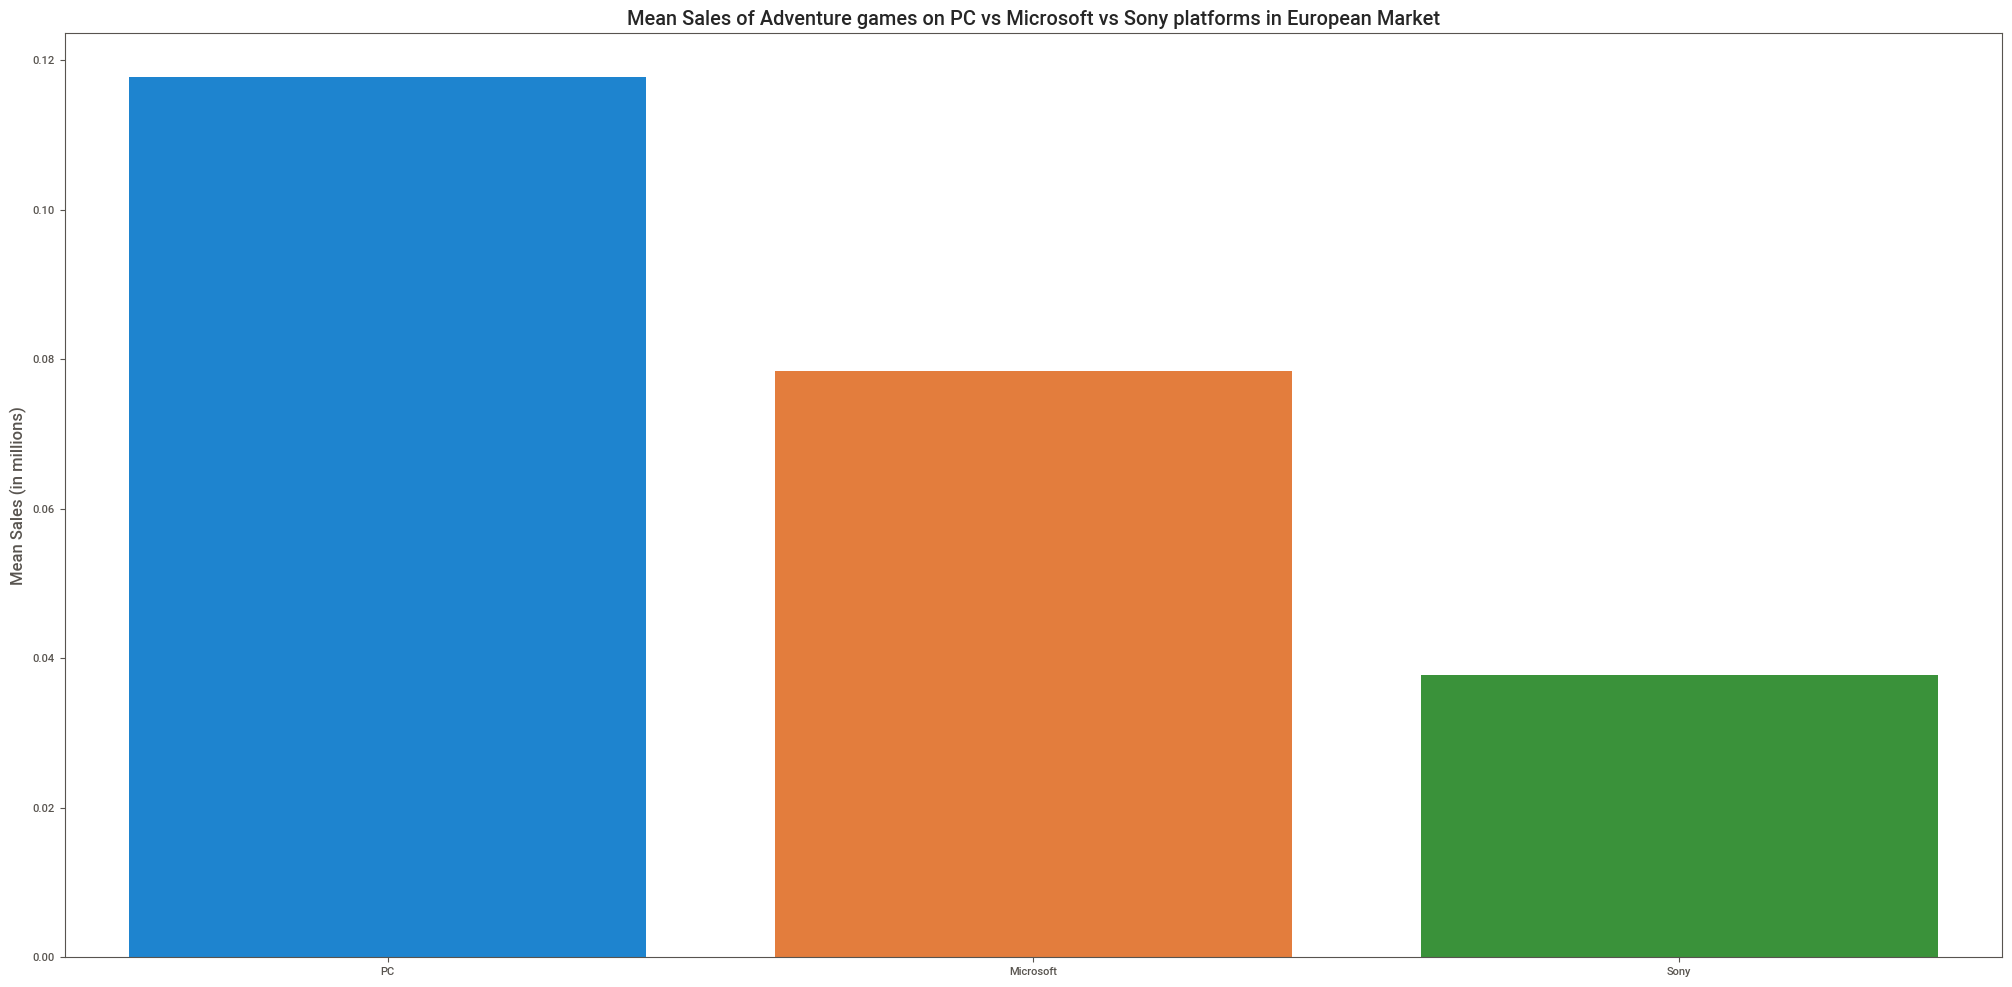

In [28]:
# Filter the data for Adventure games
adventure_games = exploratory_data_analysis[exploratory_data_analysis['genre'] == 'Adventure']

# Identify Microsoft platforms from our dataset (like X360, XB, XOne)
microsoft_platforms = ['X360', 'XB', 'XOne']

# Calculate the mean sales for Adventure games on PC, Microsoft, and Sony platforms in the European market
means_adventure = {
    'PC': adventure_games[adventure_games['platform'] == 'PC']['eu_sales'].mean(),
    'Microsoft': adventure_games[adventure_games['platform'].isin(microsoft_platforms)]['eu_sales'].mean(),
    'Sony': adventure_games[adventure_games['platform'].isin(sony_platforms)]['eu_sales'].mean()
}

# Plot the means
sns.barplot(x=list(means_adventure.keys()), y=list(means_adventure.values()))
plt.ylabel('Mean Sales (in millions)')
plt.title('Mean Sales of Adventure games on PC vs Microsoft vs Sony platforms in European Market')
plt.show();

### 4. Hypothesis: PC games have a sales mean that's 15% higher than nintendo console games in the North American market.

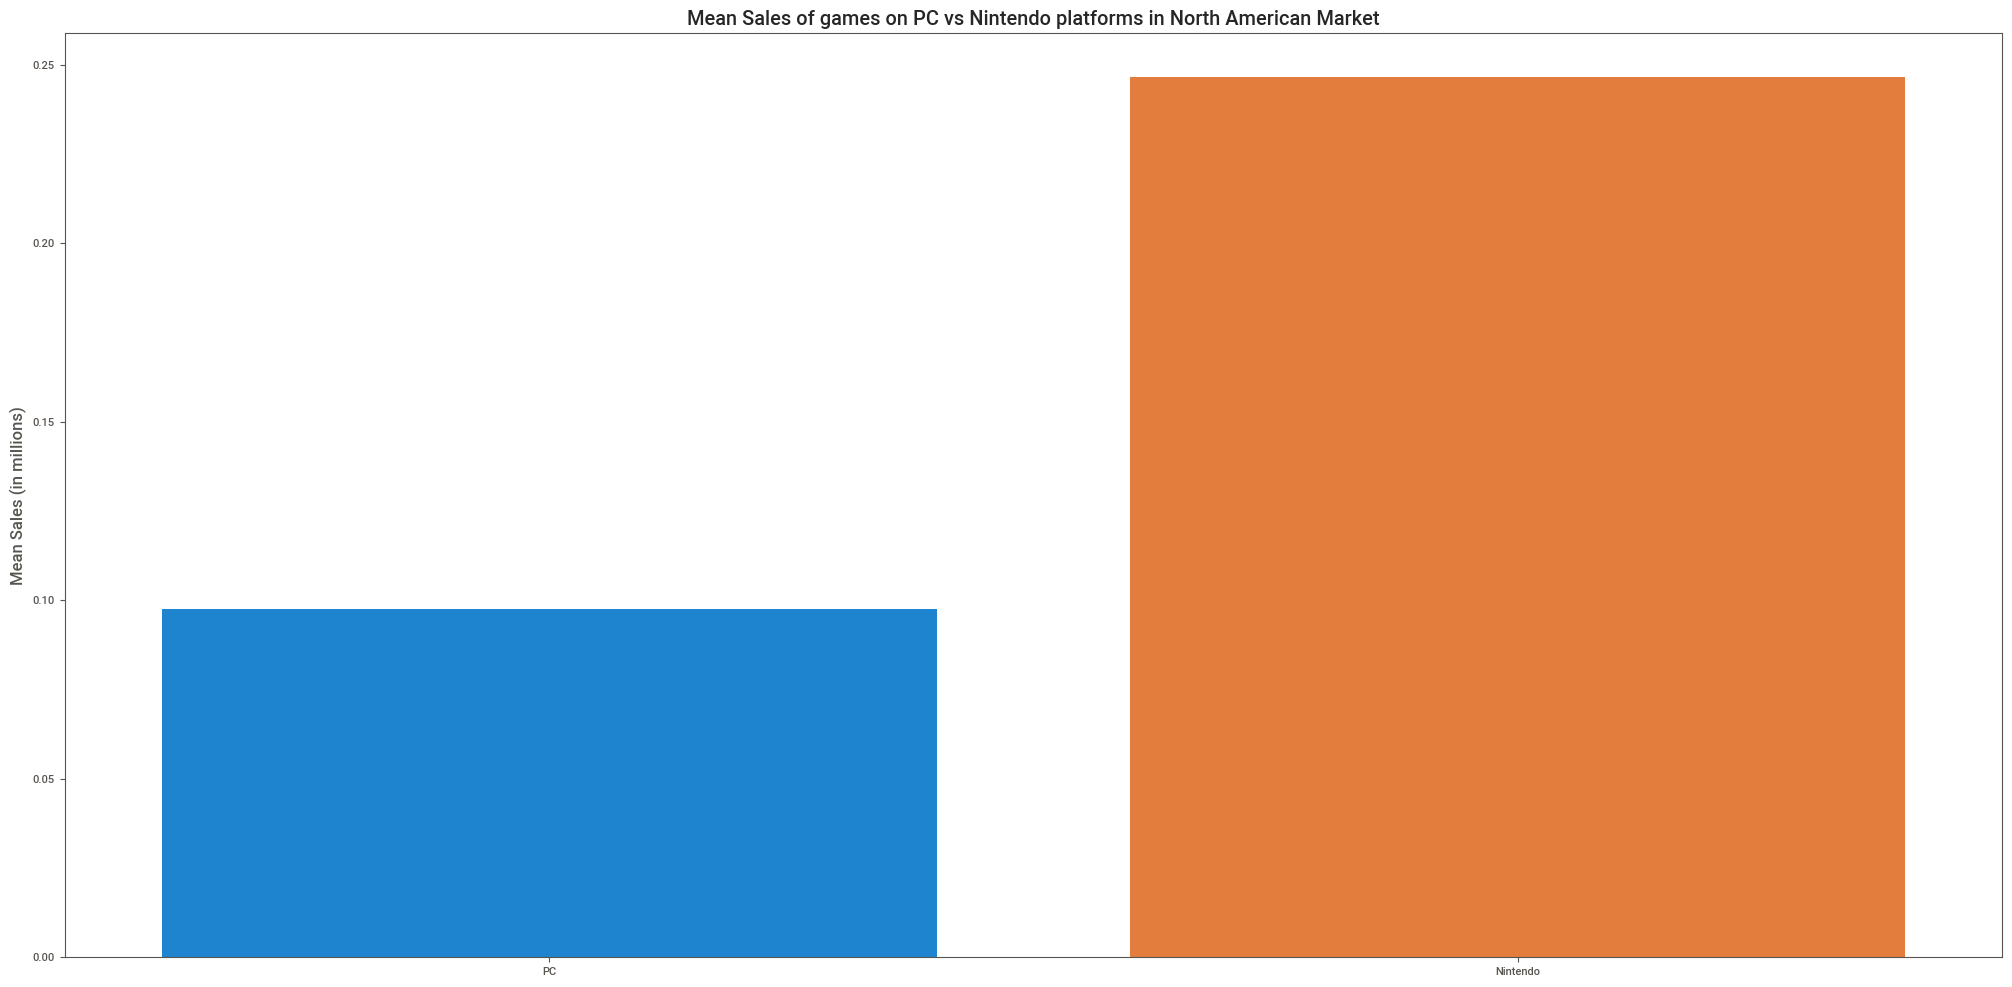

In [29]:
# Calculate the mean sales for games on PC and Nintendo platforms in the North American market
means_pc_nintendo = {
    'PC': exploratory_data_analysis[exploratory_data_analysis['platform'] == 'PC']['na_sales'].mean(),
    'Nintendo': exploratory_data_analysis[exploratory_data_analysis['platform'].isin(nintendo_platforms)]['na_sales'].mean()
}

# Plot the means
sns.barplot(x=list(means_pc_nintendo.keys()), y=list(means_pc_nintendo.values()))
plt.ylabel('Mean Sales (in millions)')
plt.title('Mean Sales of games on PC vs Nintendo platforms in North American Market')
plt.show();

### 5. Hypothesis: Games published by Electronic Arts have a sales average that's 25% higher than those published by Ubisoft in the Japan market.

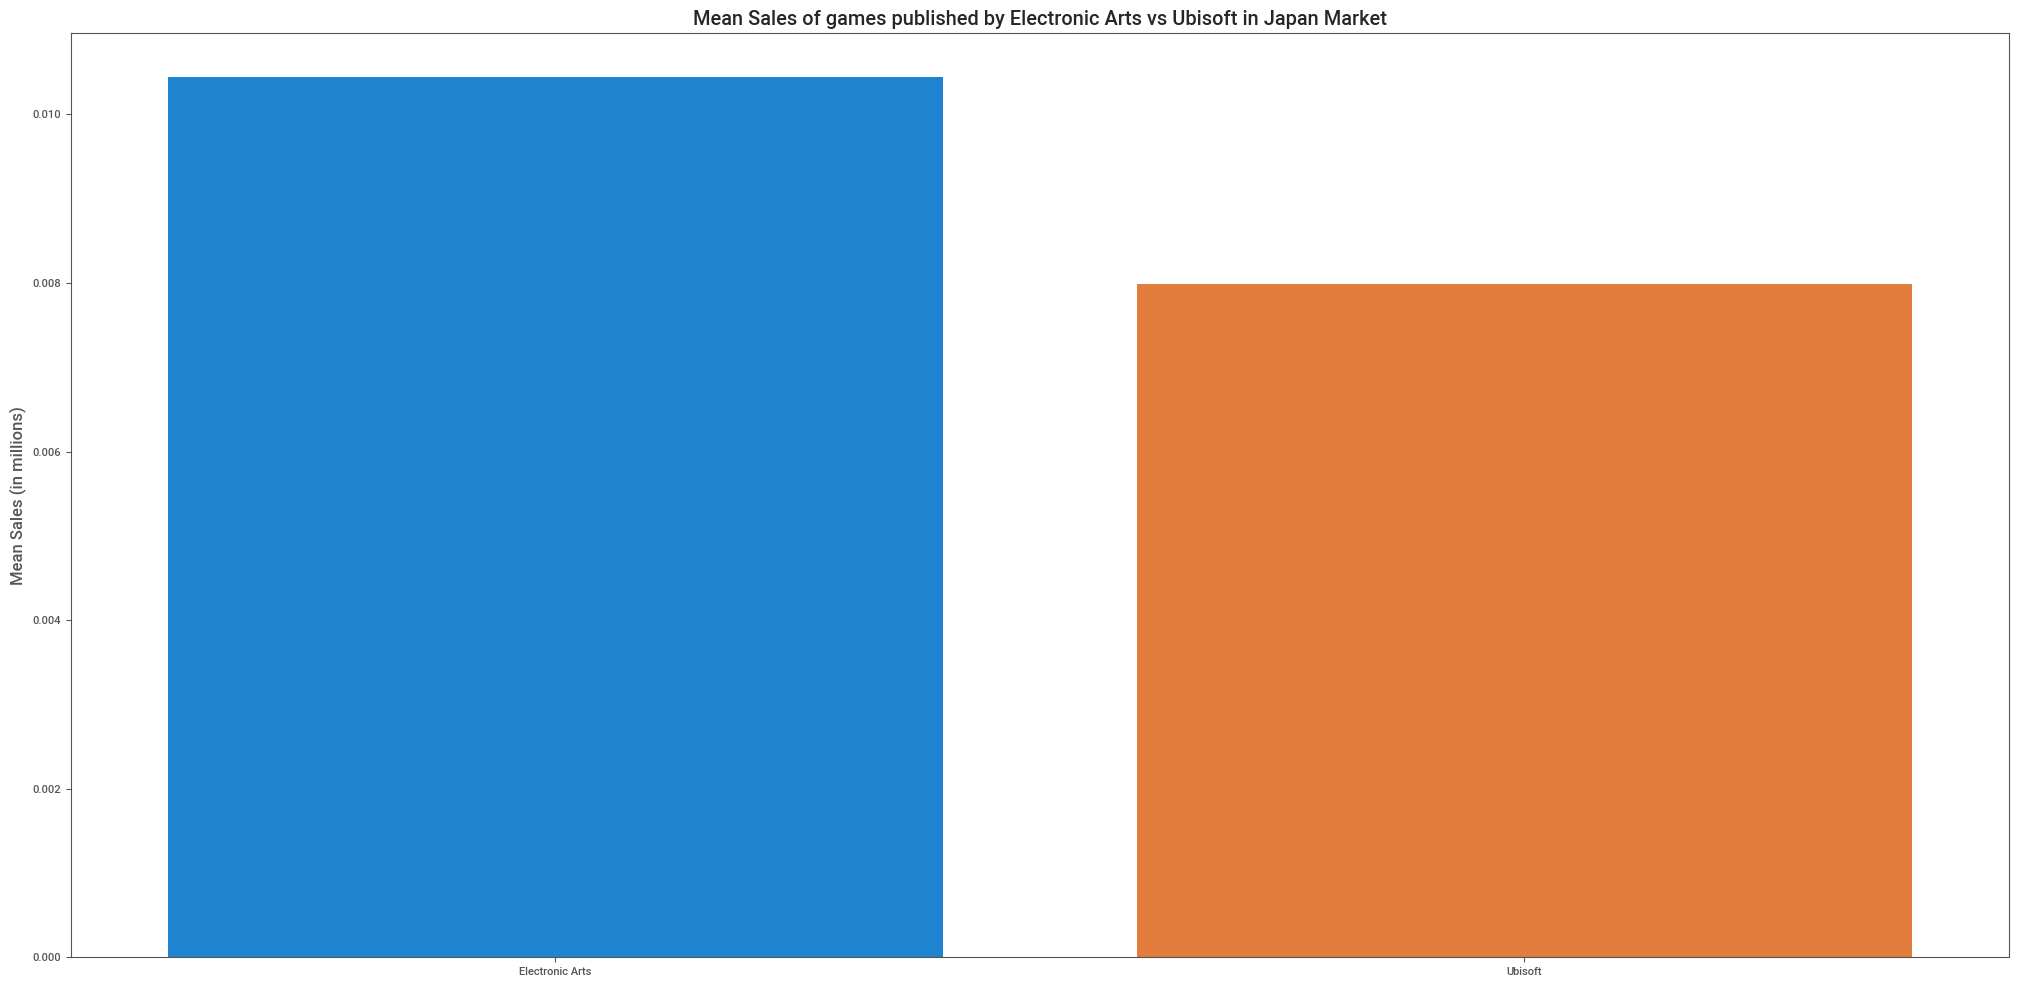

In [30]:
# Filter games published by Electronic Arts and Ubisoft
ea_games = exploratory_data_analysis[exploratory_data_analysis['publisher'] == 'Electronic Arts']
ubisoft_games = exploratory_data_analysis[exploratory_data_analysis['publisher'] == 'Ubisoft']

# Calculate the mean sales for both publishers in the Japan market
means_publishers = {
    'Electronic Arts': ea_games['jp_sales'].mean(),
    'Ubisoft': ubisoft_games['jp_sales'].mean()
}

# Plot the means
sns.barplot(x=list(means_publishers.keys()), y=list(means_publishers.values()))
plt.ylabel('Mean Sales (in millions)')
plt.title('Mean Sales of games published by Electronic Arts vs Ubisoft in Japan Market')
plt.show();

### 4.2.1 Summary of Hypotheses

In [24]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'],
       ['H2', 'False', 'Low'],
       ['H3', 'True', 'Low'],
       ['H4', 'False', 'Medium'],
       ['H5', 'False', 'Low'],
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            False         Low
H3            True          Low
H4            False         Medium
H5            False         Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

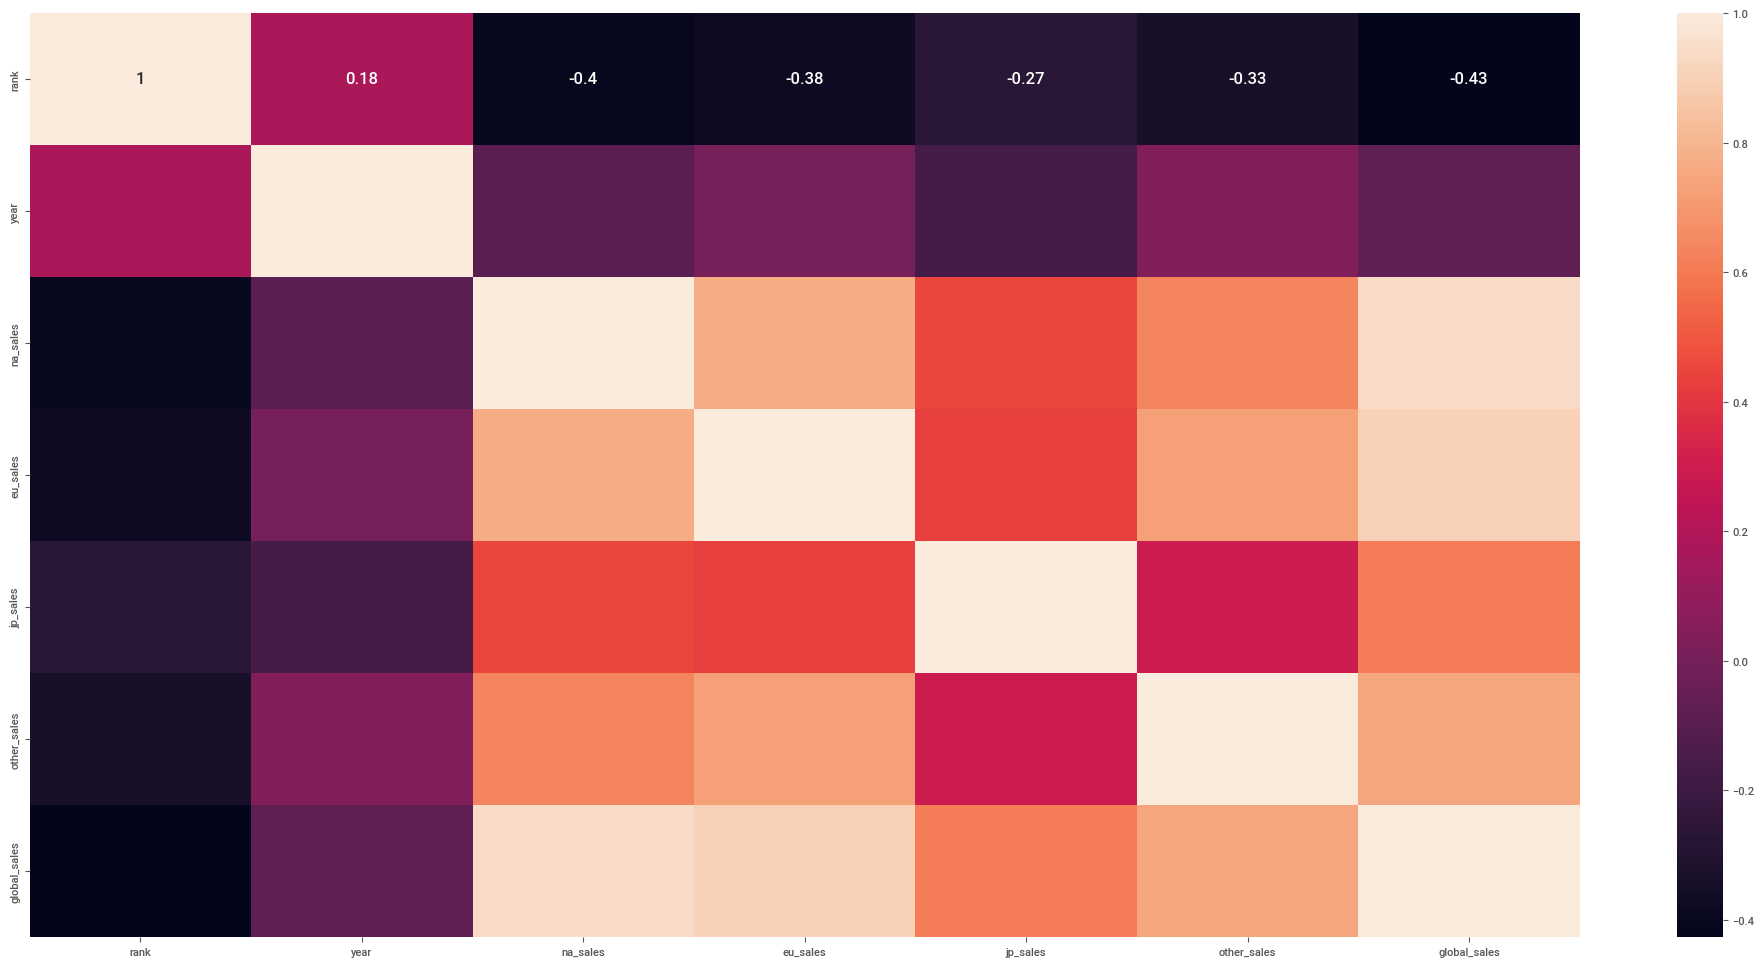

In [25]:
num_attributes = exploratory_data_analysis.select_dtypes(include='number')

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

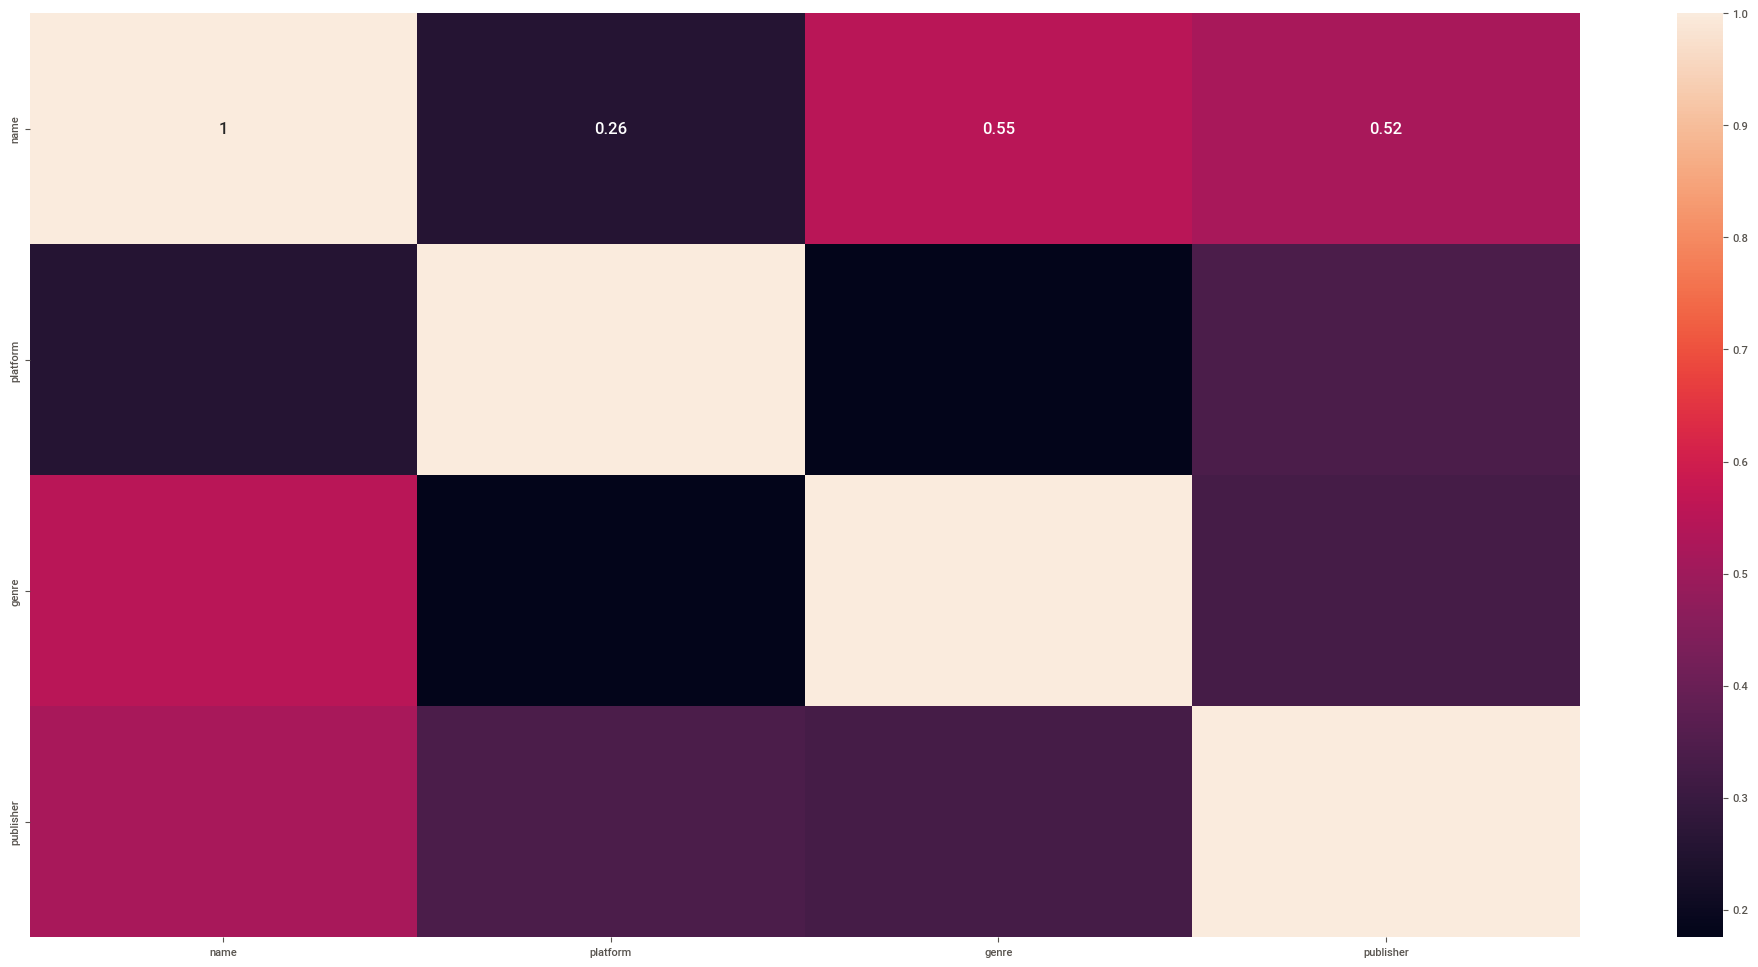

In [26]:
# only categorical data
cat_attributes = exploratory_data_analysis.select_dtypes(include='object')

# Cramer V correlation
correlation = pycorrcat.corr_matrix(cat_attributes, list(cat_attributes.columns))
sns.heatmap(correlation, annot=True);

In [27]:
catalog.save("exploratory_data_analysis", exploratory_data_analysis)

[09/21/23 20:57:23] INFO     Saving data to 'exploratory_data_analysis' (CSVDataSet)...         ]8;id=8292;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=49752;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\